## Taichung DE forecast by Neural Network

Data from TaiChung DE PV plant, CWB WUQI weather.

Collect 2016/01/01-2017/12/31.

Time frequcy: 1 hour.

Try LSTM to forecast.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM

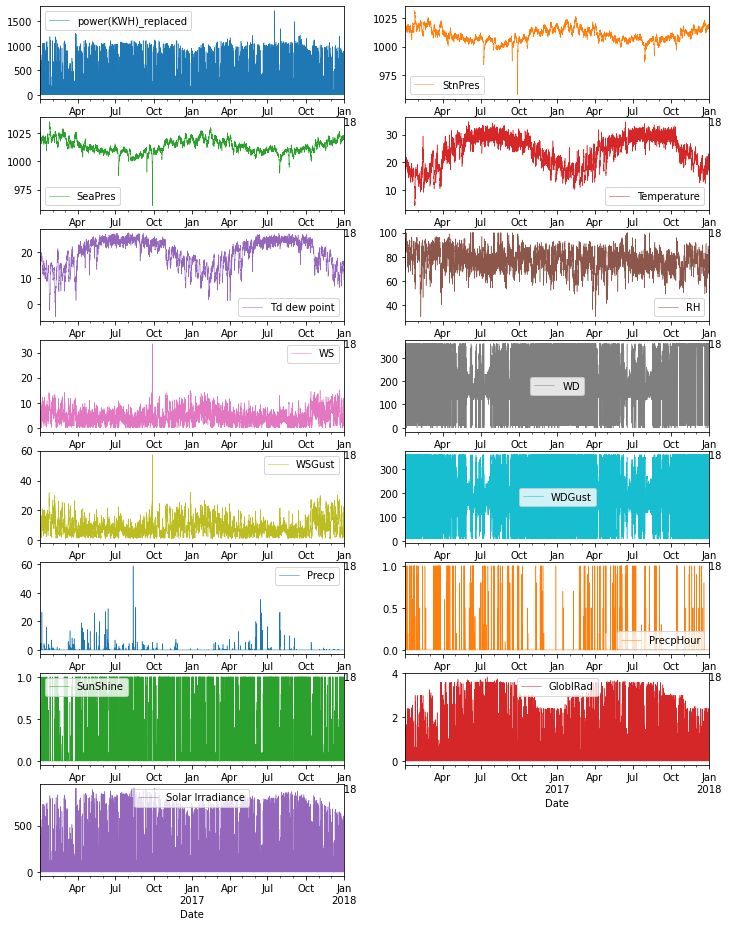

In [2]:
# quick look data
data = pd.read_csv('data\\Taichung_Power_Weather.csv', parse_dates=['Date'], index_col='Date')
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(8, 2), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

In [3]:
# replace outlier
def replace_outlier(series):
    series_mean = series.mean()
    series_std = series.std()
    upper = series_mean + 3 * series_std 
    lower = series_mean - 3 * series_std
    series_new = np.where(series > upper, upper, np.where(series < lower, lower, series))
    return series_new

# choose day time
daytime_idx = ((6<= data.index.hour) & (data.index.hour<= 18))

for col in data.columns:
    data.loc[daytime_idx,col] = replace_outlier(data.loc[daytime_idx,col])

print(data.describe().transpose())

                       count         mean         std    min     25%  \
power(KWH)_replaced  17544.0   209.294939  321.275290    0.0     0.0   
StnPres              17544.0  1010.076906    5.955720  968.3  1006.0   
SeaPres              17544.0  1013.185280    6.024415  971.3  1009.1   
Temperature          17544.0    23.592488    5.628341    4.5    19.0   
Td dew point         17544.0    19.334223    5.609826   -5.1    15.2   
RH                   17544.0    77.577017    9.002862   30.0    72.0   
WS                   17544.0     4.345607    2.726079    0.0     2.2   
WD                   17544.0   224.331110  132.654749    0.0   130.0   
WSGust               17544.0     8.942524    5.387140    1.0     4.8   
WDGust               17544.0   189.718422  134.655439   10.0    30.0   
Precp                17544.0     0.122649    0.815110    0.0     0.0   
PrecpHour            17544.0     0.047357    0.178974    0.0     0.0   
SunShine             17544.0     0.236674    0.389668    0.0    

Drop WS, WD, WDGust and WDGust because this is PV forecast.

Drop Precp and PrecpHour ,because 75% data are zero.

In [4]:
data_drop = data.drop(columns=['WS', 'WD', 'WSGust', 'WDGust', 'Precp', 'PrecpHour'])

# Creating time-lagged features
def create_lags(df, col ,N):
    for i in N:
        df[col+'_Lag_' + str(i)] = df[col].shift(i)
    return df

for col in data_drop.columns:
    data_lag=create_lags(data_drop, col,[1,24])

data_lag.dropna(inplace=True)

In [5]:
# choose day time
daytime_idx = (6<= data_lag.index.hour) & (data_lag.index.hour<= 18)
# choose feature and target
Feature = data_lag.loc[daytime_idx,'power(KWH)_replaced_Lag_1':]
Target = data_lag.loc[daytime_idx, ['power(KWH)_replaced']]
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(Feature, Target, test_size=0.166,shuffle=False)

Norm value: mean = 0, std = 1

In [6]:
# Normalize
scale = StandardScaler()
X_train_norm = scale.fit_transform(X_train)
y_train_norm = scale.fit_transform(y_train)

In [12]:
# build model
def build_model(in_shape):
      model = Sequential([
        Dense(64, activation='relu', input_shape=(in_shape,)),
        Dense(64, activation='relu'),
        Dense(1)
      ])

      optimizer = keras.optimizers.RMSprop(0.001)

      model.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=['mean_squared_error'])
      return model

model = build_model(X_train_norm.shape[1])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                1216      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# The patience parameter is the amount of epochs to check for improvement
callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")

history = model.fit(X_train_norm, y_train_norm, epochs=100,
                    validation_split = 0.2, verbose=0, callbacks=[callback])

Epoch 00012: early stopping


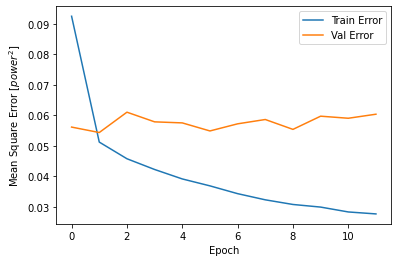

In [15]:
# Display training progress by printing a single dot for each completed epoch

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$power^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label='Val Error')

    plt.legend()
    plt.show()

plot_history(history)

In [16]:
X_test_norm = scale.fit_transform(X_test)
y_test_norm = scale.fit_transform(y_test)

loss, mse = model.evaluate(X_test_norm, y_test_norm, verbose=0)


test_predictions = model.predict(X_test_norm).flatten()

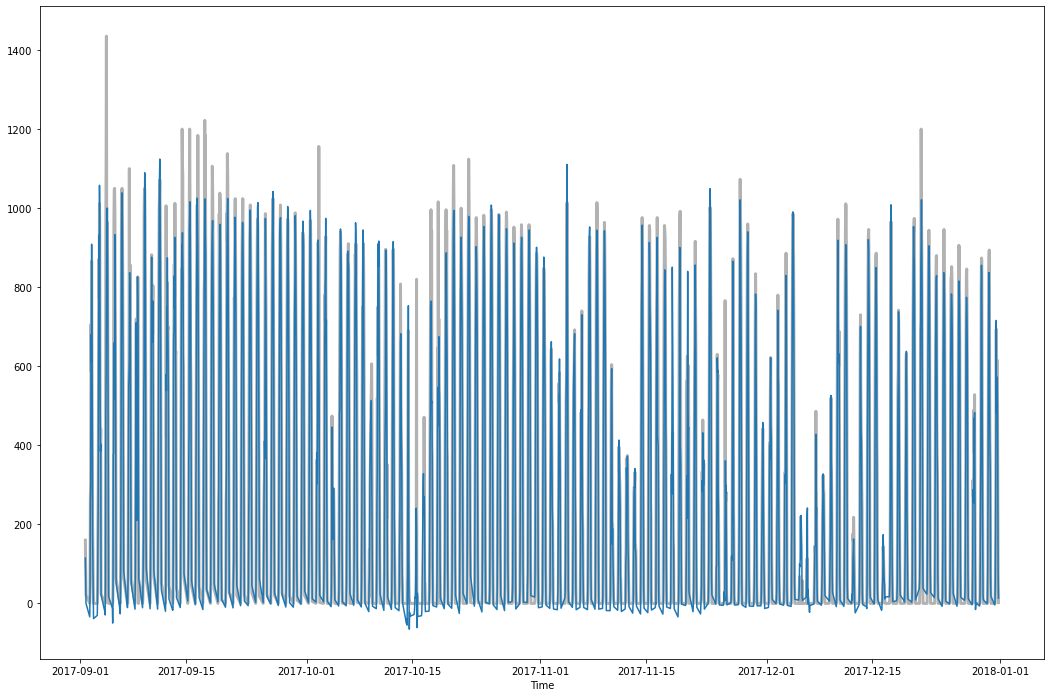

In [28]:
y_predict = scale.inverse_transform(test_predictions).reshape(-1,1)
# visualizing predict
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(y_test, color='k', alpha=.3, lw=3)
ax.plot(y_test.index, y_predict)
ax.set(xlabel="Time")
plt.show()

In [29]:
def MRE(x,y):
    return np.nanmean(np.abs((x-y)/np.max(x)))

print('Mean squared error:{:.4f}'.format(mean_squared_error(y_test,y_predict)))
print('Mean absolute error:{:.4f}'.format(mean_absolute_error(y_test,y_predict)))
print('Mean relative error:{:.2%}'.format(MRE(y_test,y_predict)))
print('Coefficient of determination:{:.4f}'.format(r2_score(y_test,y_predict)))

Mean squared error:8529.4854
Mean absolute error:47.1380
Mean relative error:3.28%
Coefficient of determination:0.9313
